In [1]:
import math as m
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt

from pymatgen.util import coord
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.core.structure import Structure
from pymatgen.core.periodic_table import Element
from pymatgen.core.sites import Site
from ase.visualize.plot import plot_atoms
from copy import copy, deepcopy

In [34]:
#Todo: добавить функцию дефектов Mo-Mo

def vacanciesS_S(x):
    return 2.693 - 1/(15 + 2 * x)

def vacanciesS_SoneLayer(x):
    return 2.669 + m.cos(1 - x) /(15 + 2 * x)

def vacanciesS_SdifLayer(x):
    return 2.693 + m.cos(5 - x) / ((2**x) + 1 + x)

def vacanciesS_Mo(x):
    return 4.895 + (m.cos(0.5) * m.cos(8 - 2 * x) - 1)* x**2 * m.exp(-x)

In [3]:
def printStructure(d):
    s0 = d.initial_structure
    d0 = list(d.defect_representation)
    ase_atoms = AseAtomsAdaptor.get_atoms(s0)
    fig, ax = plt.subplots()
    plot_atoms(ase_atoms, ax, radii=0.6, rotation=('10x, 0y, 0z'), show_unit_cell=True)
    xlim = 40
    ylim = 23
    ax.set_xlim(-2, xlim)
    ax.set_ylim(-2, ylim)
    ax.set_title(f'{d0}')

In [31]:
def distanceCalc(i, defect, databegin):
    x = (dataBegin.initial_structure[i].frac_coords[0] - dataBegin.initial_structure[defect].frac_coords[0])**2
    y = (dataBegin.initial_structure[i].frac_coords[1] - dataBegin.initial_structure[defect].frac_coords[1])**2
    z = (dataBegin.initial_structure[i].frac_coords[2] - dataBegin.initial_structure[defect].frac_coords[2])**2
    distance = m.sqrt(x+y+z)
    return distance

#Todo: разделить фунцию на подфункции
def addDefect(energy, current_e, defects, defType, dataBegin):
    chosen = -1
    chosen_e = 0
    if not len(defects):
        if defType == "l1S":
            chosen = np.random.randint(64, 127)
        elif defType == "l2S":
            chosen = np.random.randint(128, 191)
        elif defType == "Mo":
            chosen = np.random.randint(0, 63)
        defects.append(chosen)
        return 0
    
    if defType == "l1S":
        for i in range(64, 128):
            if i not in defects:
                for defect in defects:
                    distance = distanceCalc(i, defect, dataBegin)
                    new_e = 0
                    if defect > 127:
                        new_e += vacanciesS_SdifLayer(distance)
                    elif defect < 64:
                        new_e += vacanciesS_Mo(distance)
                    elif defect >= 64 and defect <= 127:
                        new_e += vacanciesS_SoneLayer(distance)
                    if (new_e + current_e - energy)**2 < (chosen_e + current_e - energy)**2 or chosen == -1:
                        chosen = i
                        chosen_e = new_e
                        
    elif defType == "l2S":
        for i in range(128, 192):
            if i not in defects:
                for defect in defects:
                    distance = distanceCalc(i, defect, dataBegin)                    
                    new_e = 0
                    if defect > 127:
                        new_e += vacanciesS_SoneLayer(distance)
                    elif defect < 64:
                        new_e += vacanciesS_Mo(distance)
                    elif defect >= 64 and defect <= 127:
                        new_e += vacanciesS_SdifLayer(distance)
                    if (new_e + current_e - energy)**2 < (chosen_e + current_e - energy)**2 or chosen == -1:
                        chosen = i
                        chosen_e = new_e
                        
    elif defType == "Mo":
        for i in range(0, 68):
            if i not in defects:
                for defect in defects:
                    distance = distanceCalc(i, defect, dataBegin)
                    new_e = 0
                    if defect > 127:
                        new_e += vacanciesS_SdifLayer(distance)
                    elif defect >= 64 and defect <= 127:
                        new_e += vacanciesS_SoneLayer(distance)
                    if (new_e + current_e - energy)**2 < (chosen_e + current_e - energy)**2 or chosen == -1:
                        chosen = i
                        chosen_e = new_e
    defects.append(chosen)
    return current_e + chosen_e

In [32]:
def applyDefects(current_e, dataNew, defects):
    print("Energy:", current_e, "Defects:", defects)
    for i in range(len(defects)):
        if defects[i] < 64:
            dataNew.initial_structure.replace(defects[i], Element('W'))
        else:
            dataNew.initial_structure.replace(defects[i], Element('Li'))
        dataNew.defect_representation.append(dataNew.initial_structure[defects[i]].species, dataNew.initial_structure[defects[i]].frac_coords)
    printStructure(dataNew)
    for i in range(len(defects)):
        if defects[i] < 64:
            dataNew.initial_structure.replace(defects[i], Element('Mo'))
        else:
            dataNew.initial_structure.replace(defects[i], Element('S'))
    dataNew.defect_representation.clear()

    
def twoDefects(energy, dataBegin, elements):
    for x in elements:
        for y in elements:
            if [x,y].count('Mo') <= 1:
                defects = []
                current_e = 0
                dataNew = deepcopy(dataBegin)
                current_e = addDefect(energy, current_e, defects, x, dataNew)
                current_e = addDefect(energy, current_e, defects, y, dataNew)
                applyDefects(current_e, dataNew, defects)
                dataBegin.defect_representation.clear()
               
    
def threeDefects(energy, dataBegin, elements):
    for x in elements:
        for y in elements:
            for z in elements:
                if [x,y,z].count('Mo') <= 1:
                    defects = []
                    current_e = 0
                    dataNew = deepcopy(dataBegin)
                    current_e = addDefect(energy, current_e, defects, x, dataNew)
                    current_e = addDefect(energy, current_e, defects, y, dataNew)
                    current_e = addDefect(energy, current_e, defects, z, dataNew)
                    applyDefects(current_e, dataNew, defects)
                    dataBegin.defect_representation.clear()
                    

4
3
Energy: 5.439269213150098 Defects: [88, 87, 80]
Energy: 5.251375161424348 Defects: [78, 113, 135]
Energy: 5.439069518176623 Defects: [121, 86, 56]
Energy: 5.27588897294823 Defects: [108, 172, 64]
Energy: 5.247808046228472 Defects: [111, 175, 128]
Energy: 5.26346003643522 Defects: [89, 153, 62]
Energy: 5.439261966900707 Defects: [97, 62, 89]
Energy: 5.265503075882025 Defects: [94, 55, 184]
Energy: 5.262899767310669 Defects: [161, 97, 71]
Energy: 5.262899767310669 Defects: [158, 94, 184]
Energy: 5.27588897294823 Defects: [172, 108, 64]
Energy: 5.246459270747689 Defects: [150, 185, 71]
Energy: 5.439257424226451 Defects: [153, 191, 145]
Energy: 5.246459270747689 Defects: [145, 190, 64]
Energy: 5.29802736009106 Defects: [169, 40, 71]
Energy: 5.479349951504993 Defects: [150, 21, 158]
Energy: 7.554381100842312 Defects: [41, 74, 66]
Energy: 7.370366633578019 Defects: [34, 67, 191]
Energy: 7.333001727184675 Defects: [53, 128, 127]
Energy: 7.401537030377211 Defects: [7, 184, 176]


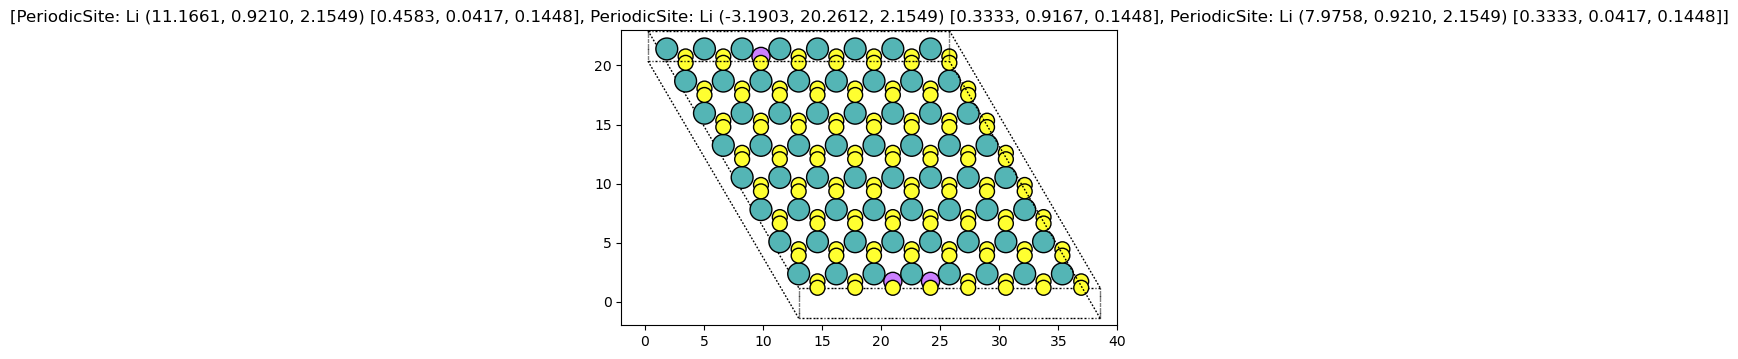

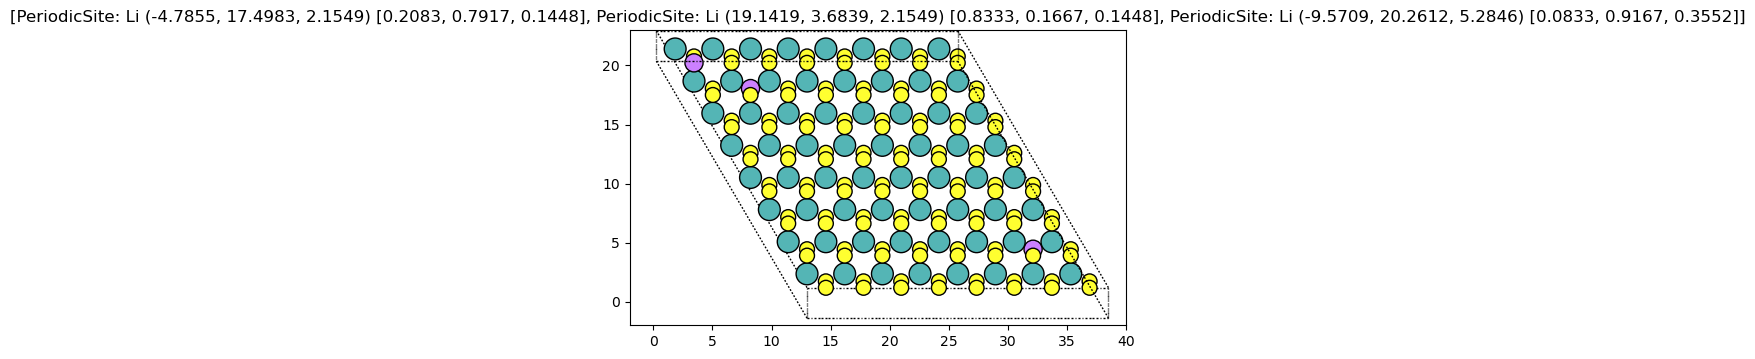

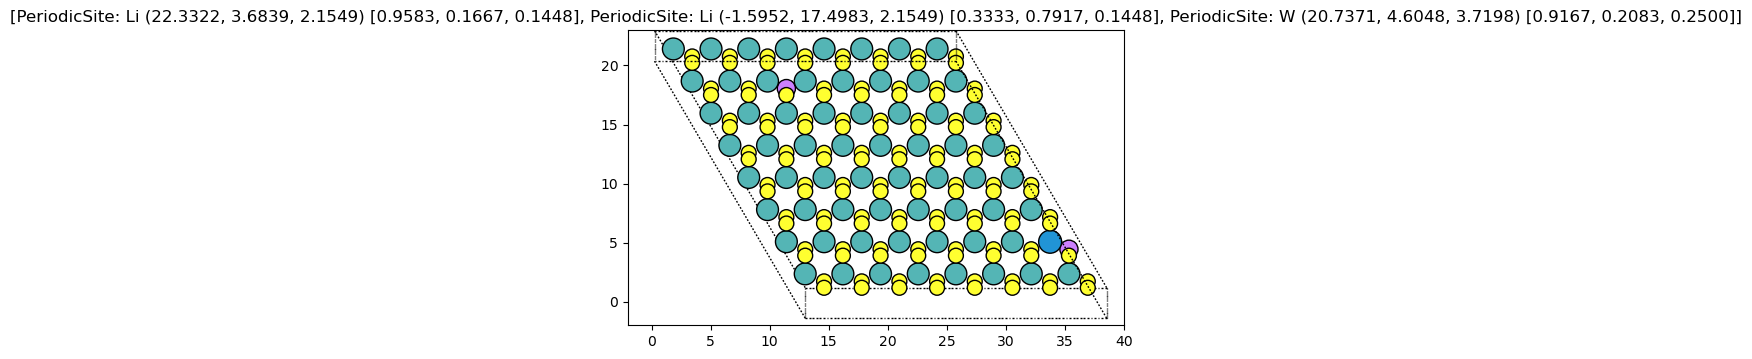

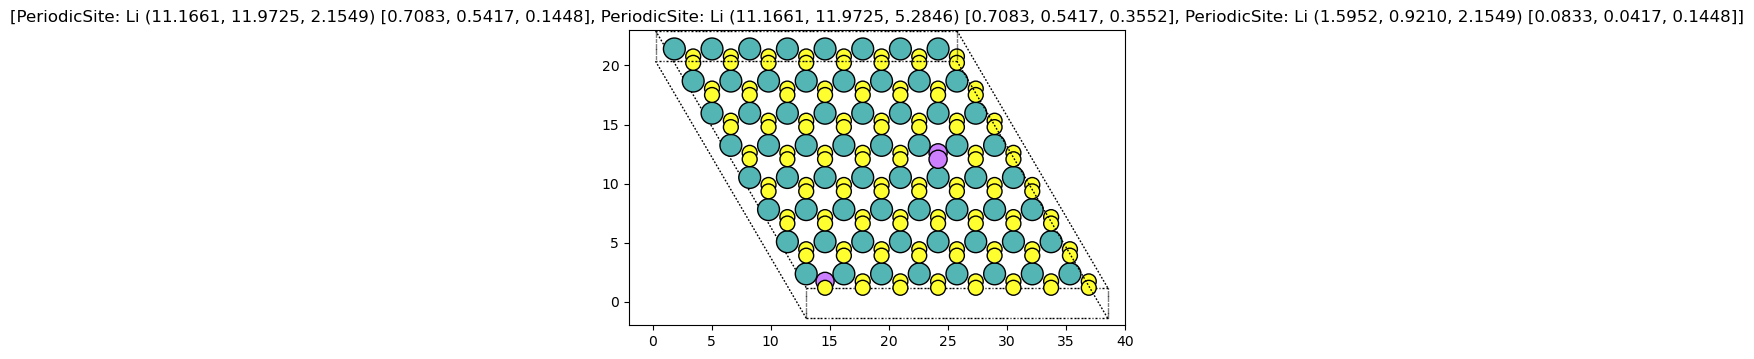

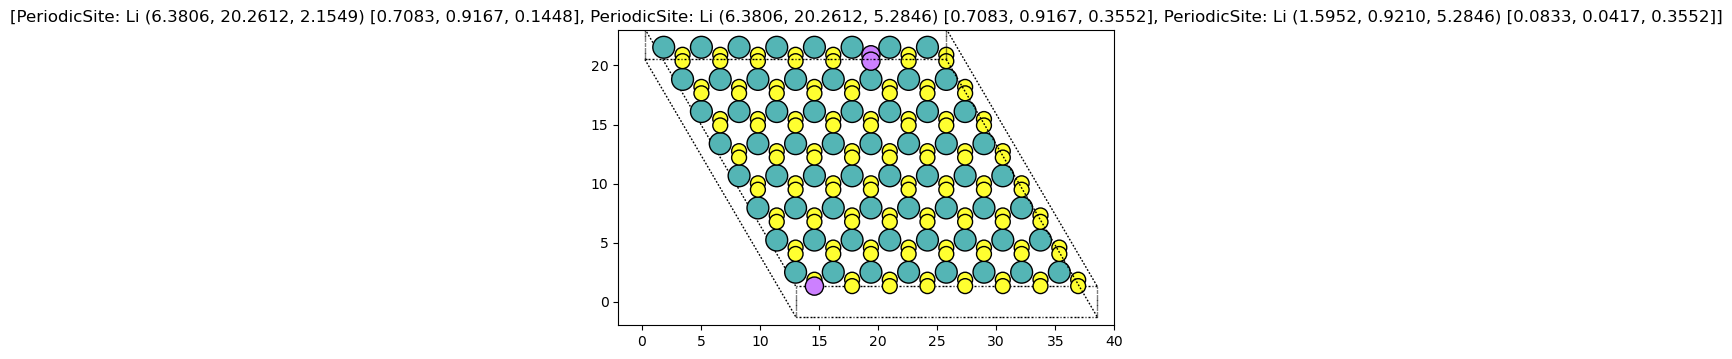

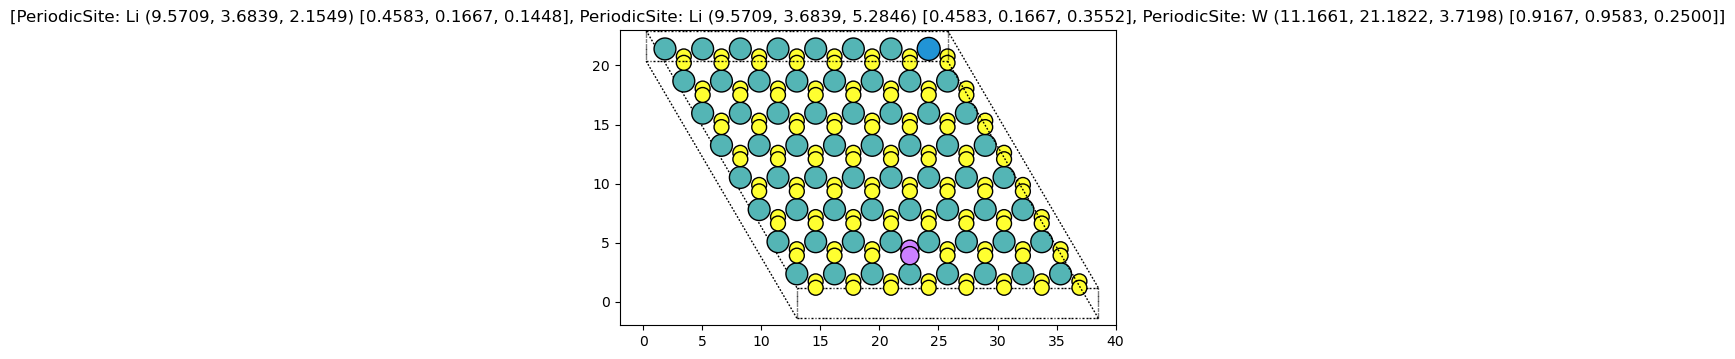

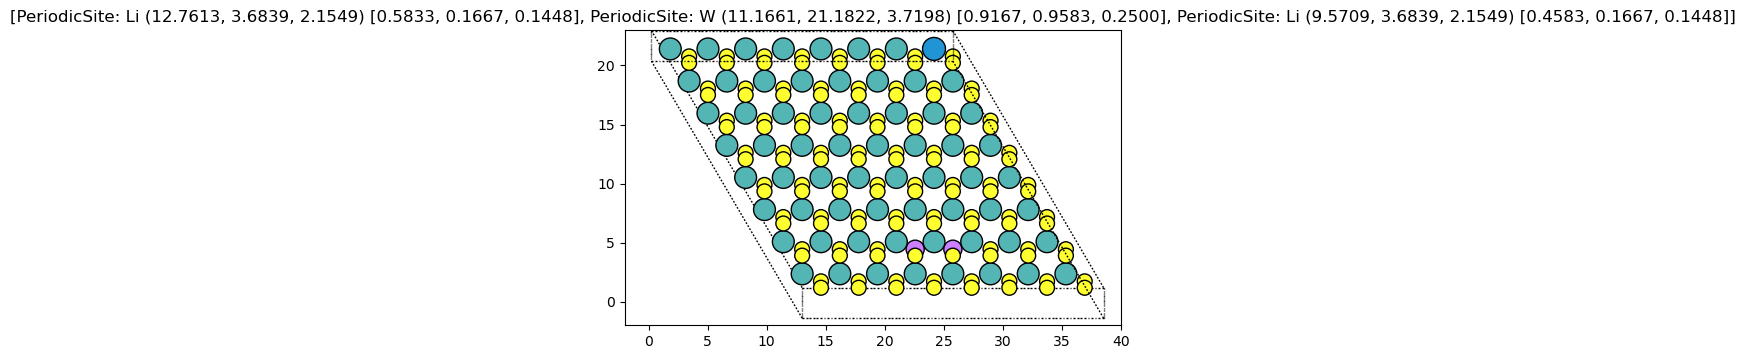

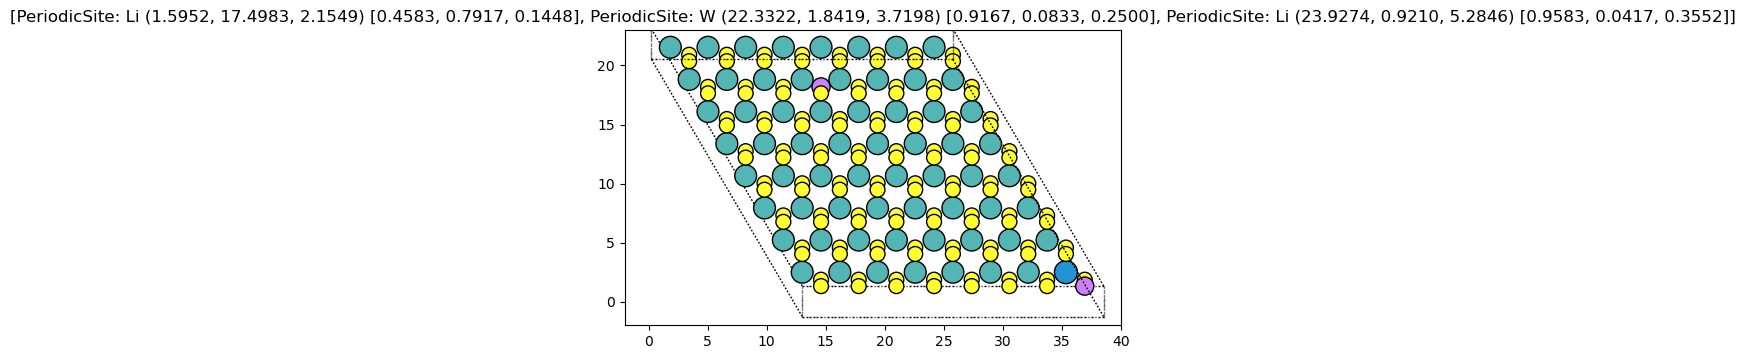

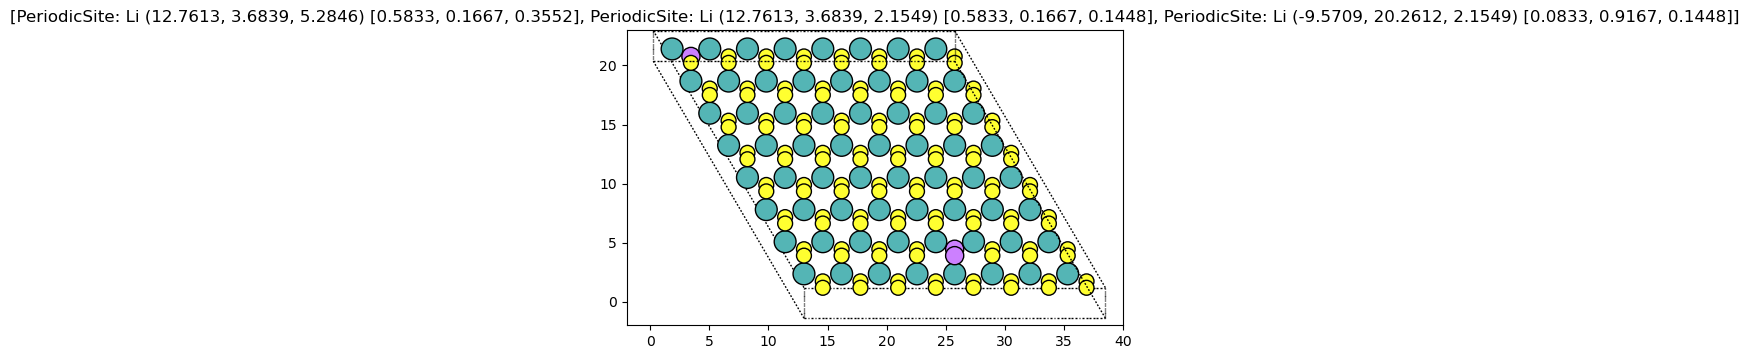

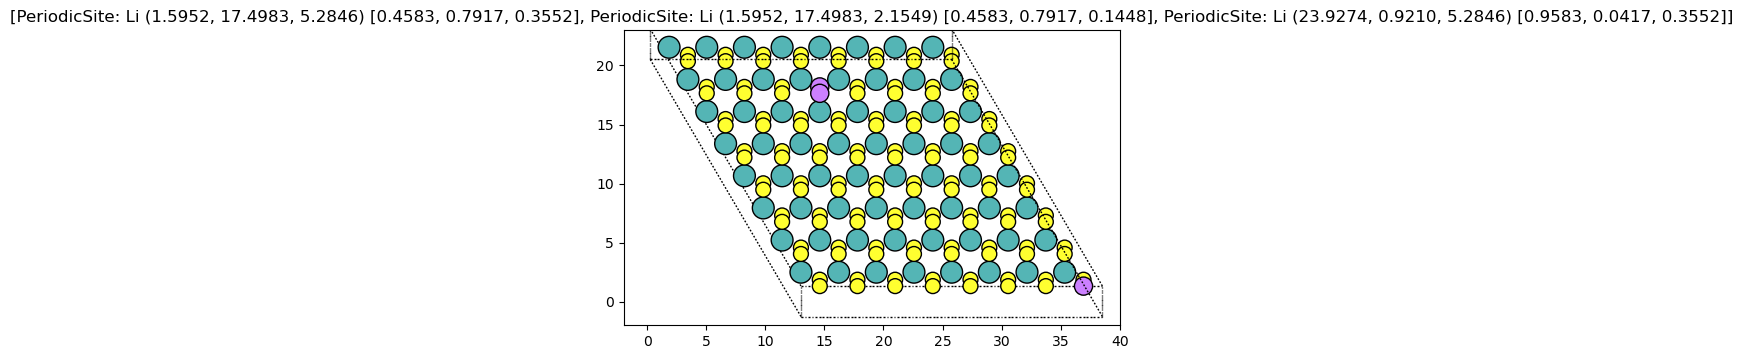

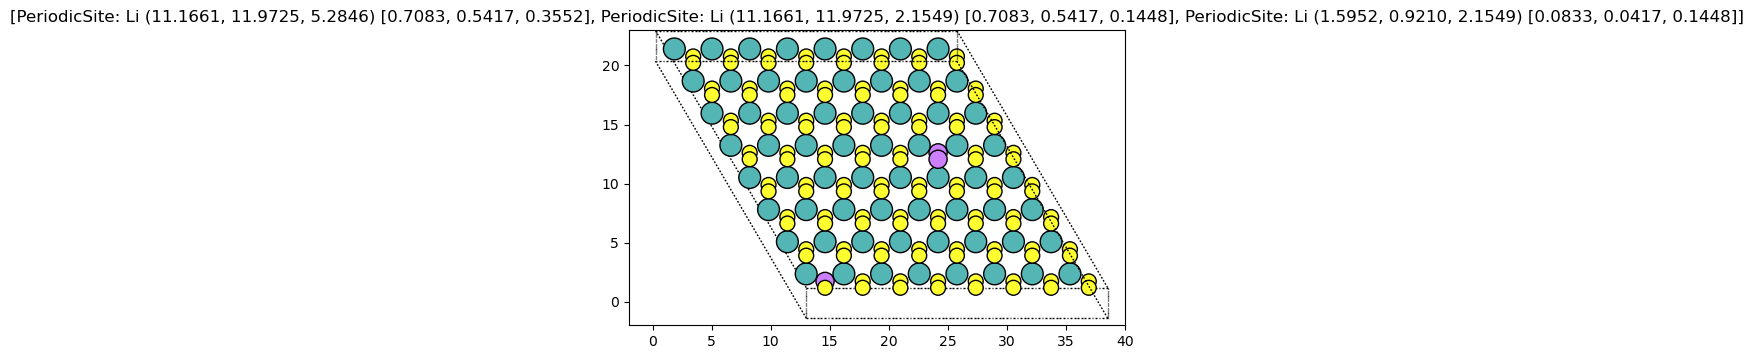

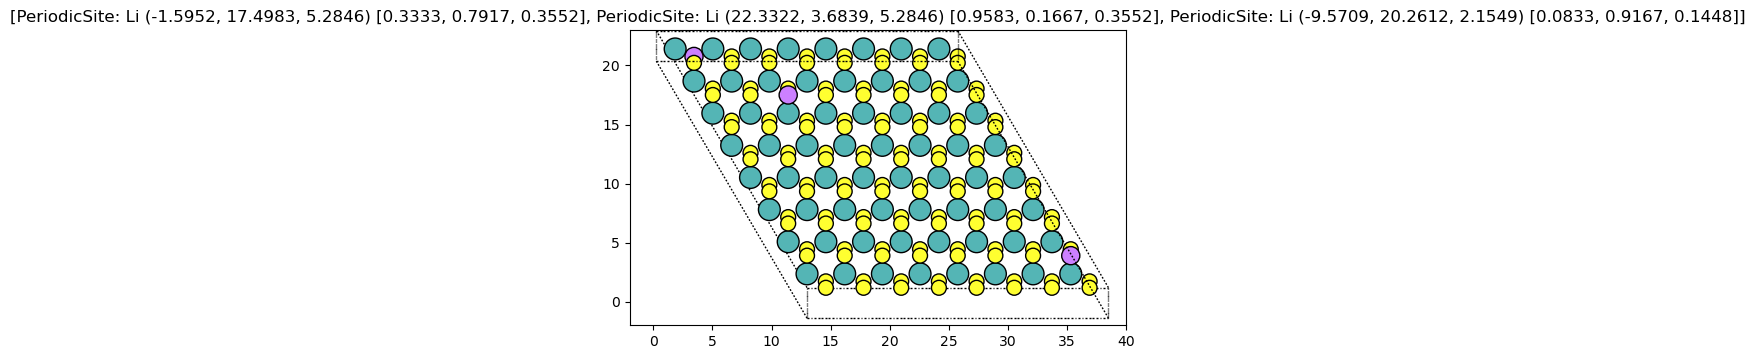

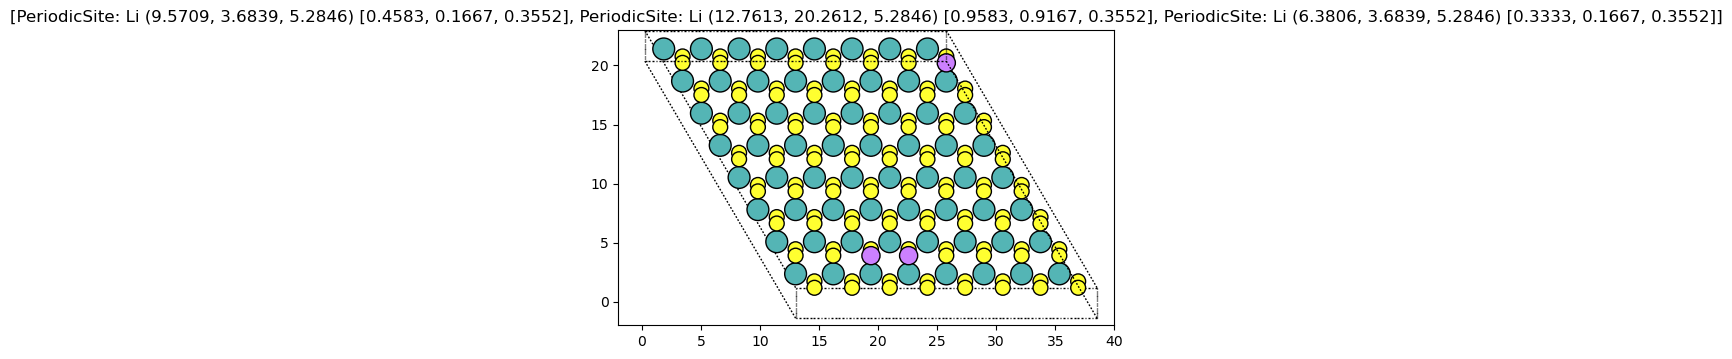

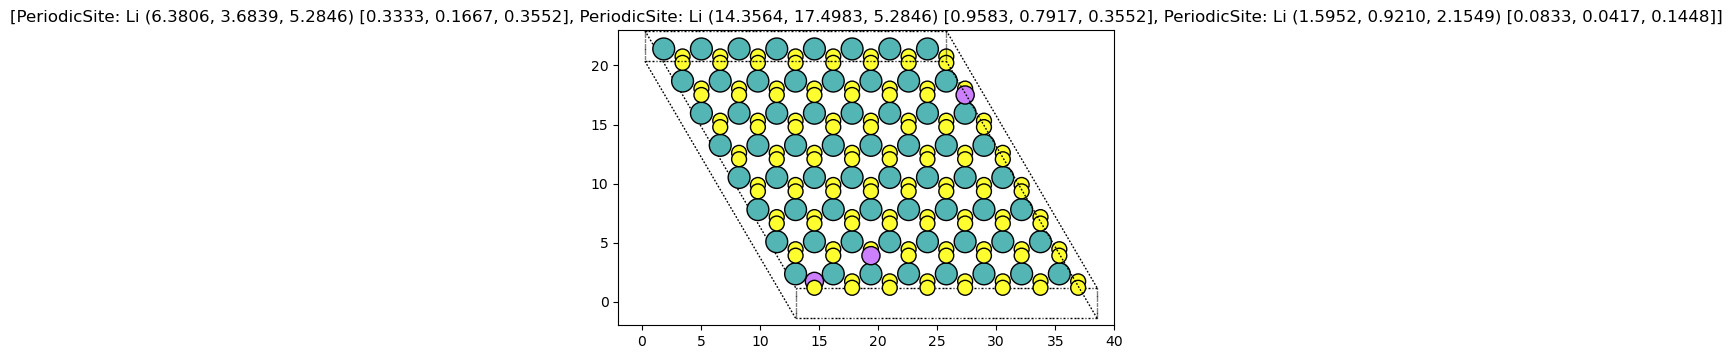

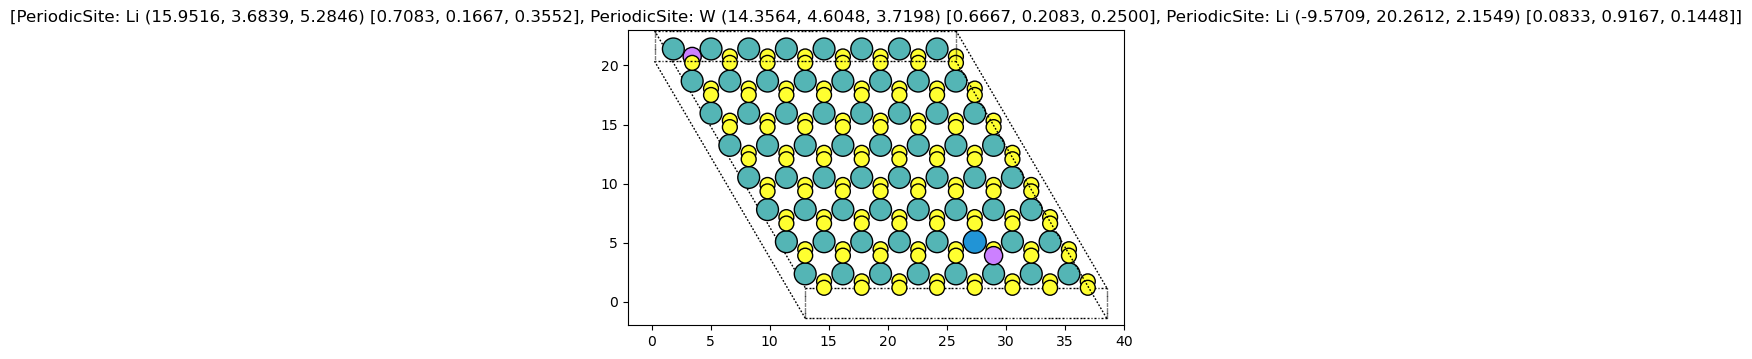

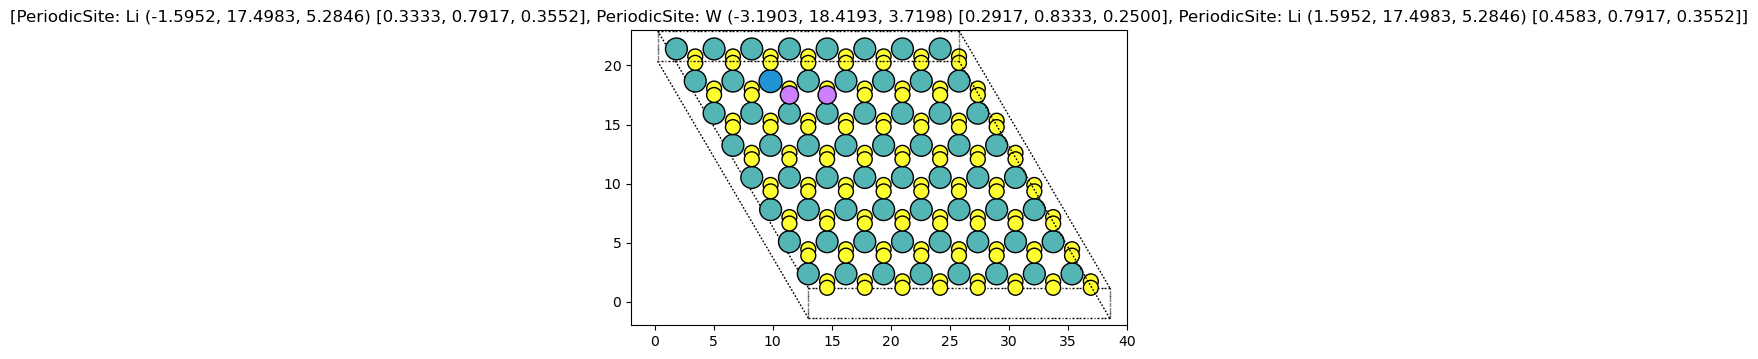

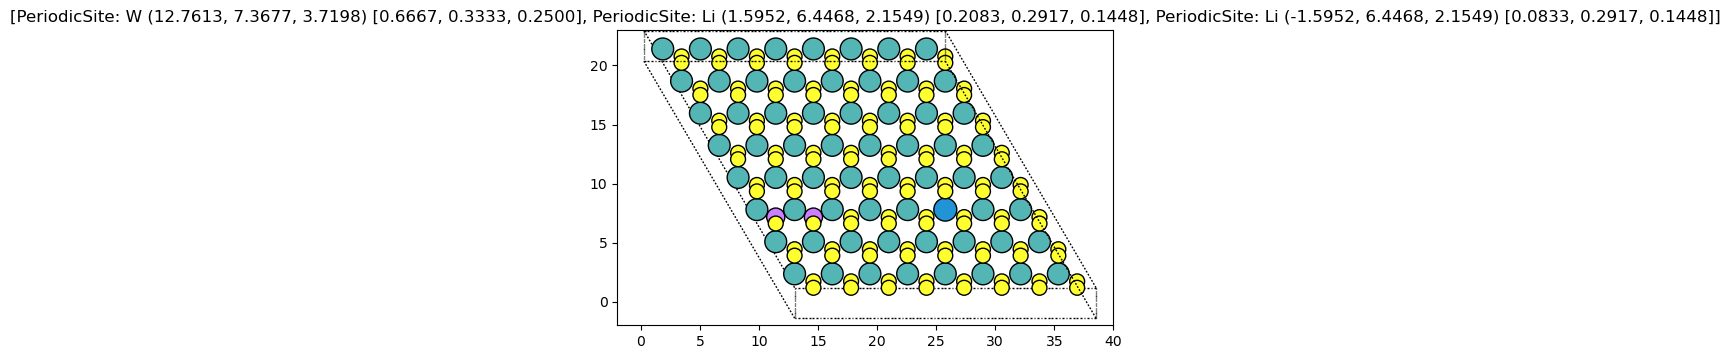

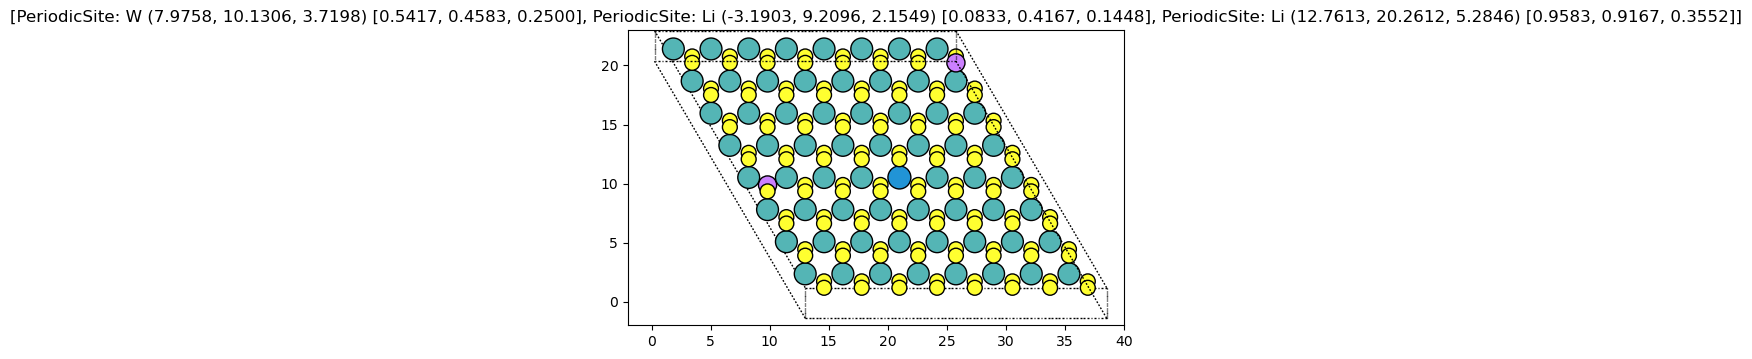

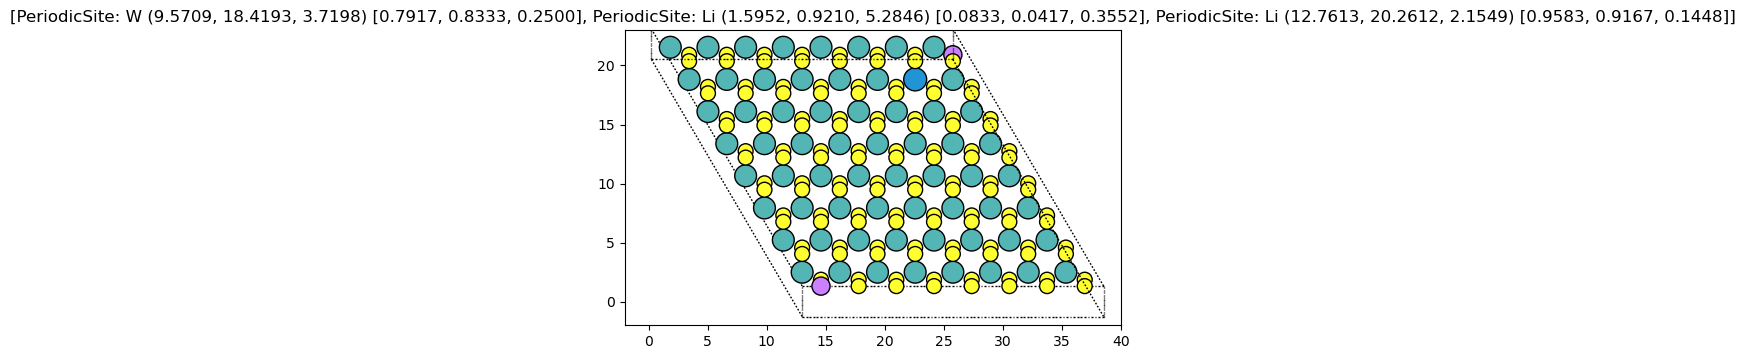

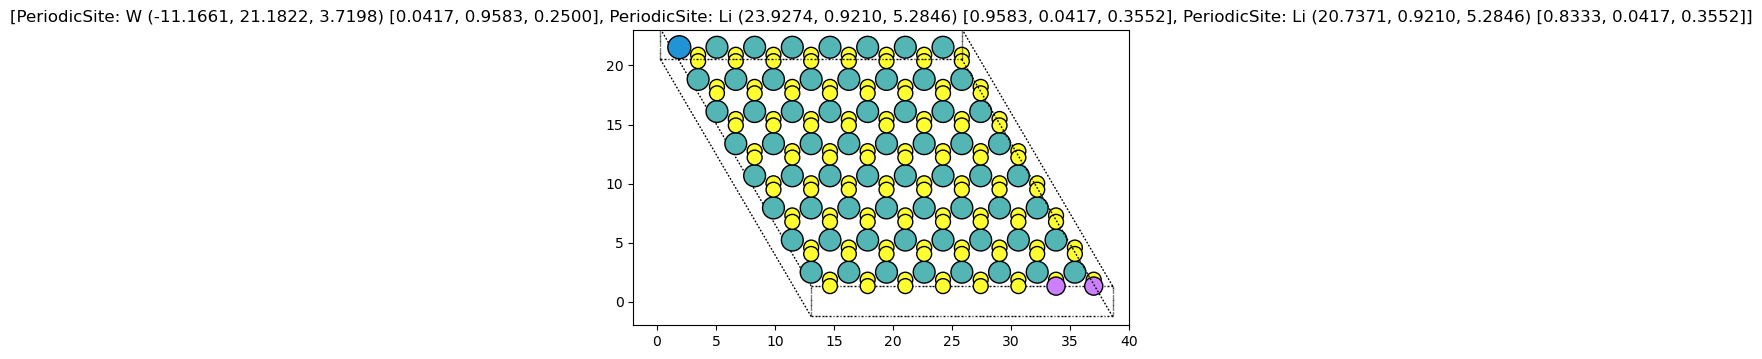

In [33]:
dataBegin = pd.read_pickle('emptydata.pkl')
dataBegin = dataBegin.iloc[0]
dataBegin.defect_representation.clear()

energy = float(input())  #expected energy
number_of_defects = int(input()) #amount of defects used
elements = ['l1S','l2S','Mo']

if number_of_defects == 2:
    twoDefects(energy, dataBegin, elements)
elif number_of_defects == 3:
    threeDefects(energy, dataBegin, elements)